In [50]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix, data_transform
from libs.visual_analysis import visualize_fit, visualize_predict
import matplotlib.pyplot as plt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import re
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [7]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [8]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


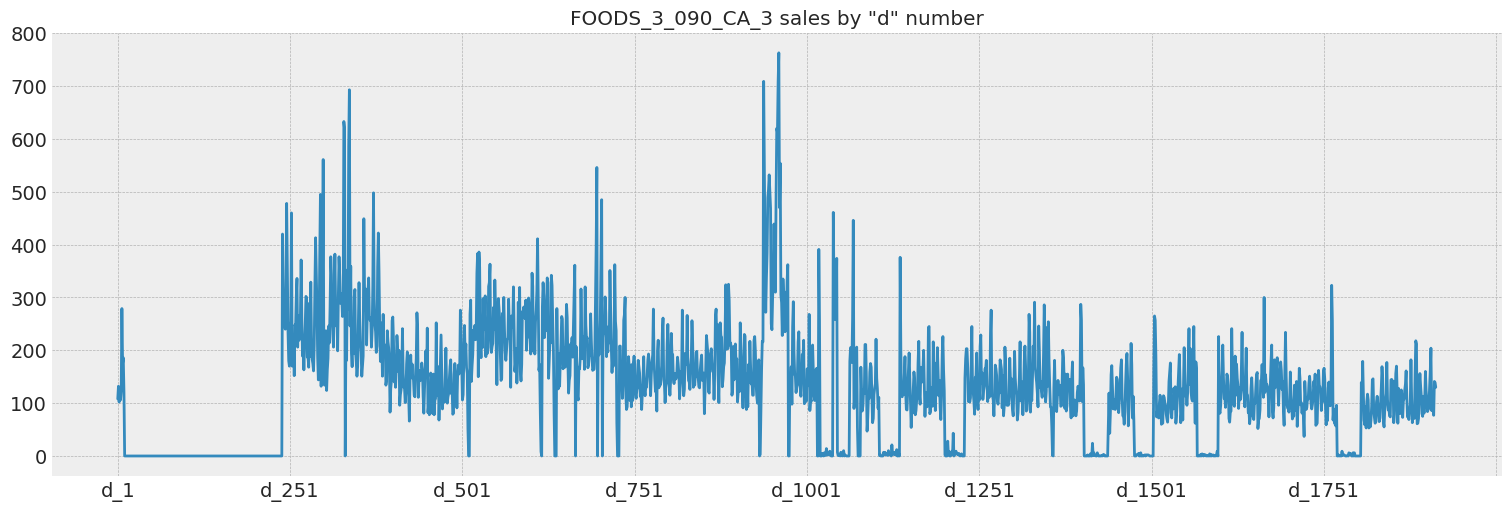

In [9]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

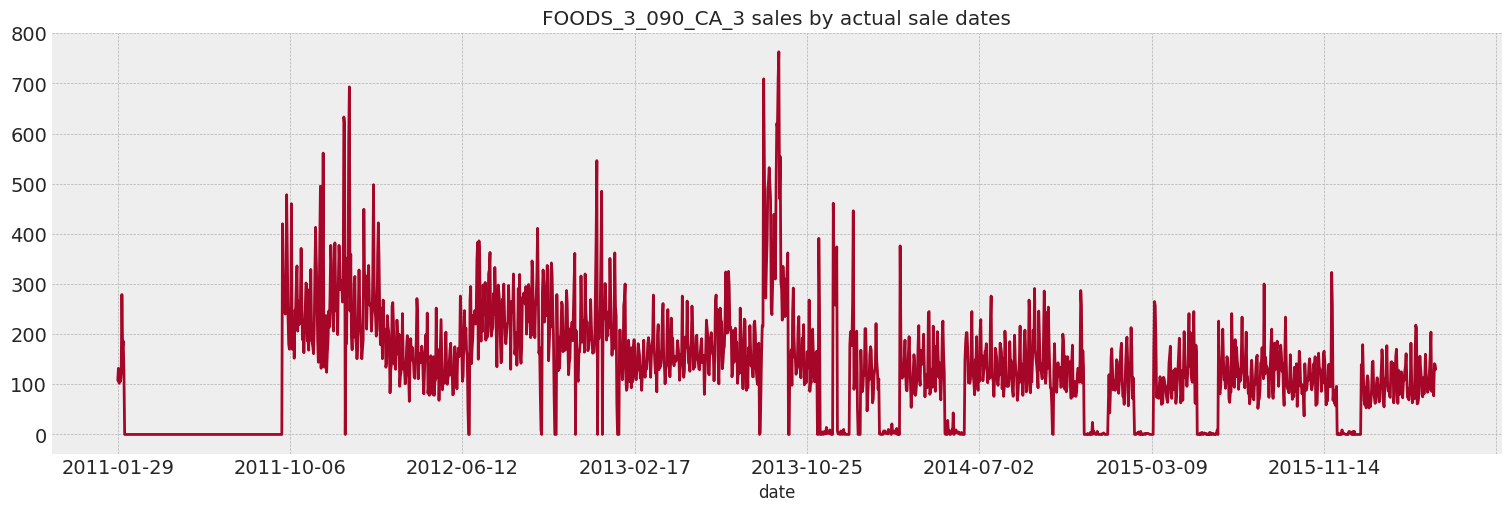

In [10]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [11]:
stv.columns[:6]

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [12]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [13]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [14]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [15]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [16]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [17]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

dept_id             object
cat_id              object
store_id            object
state_id            object
day                 object
value                int64
Date        datetime64[ns]
dtype: object

In [18]:
# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

In [19]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [20]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [32]:
groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=52, h=12)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 262
Total number of points: 274
Seasonality: 52
Forecast horizon: 12


In [33]:
groups

{'train': {'groups_idx': {'Department': array([0, 0, 0, ..., 6, 6, 6]),
   'Category': array([0, 0, 0, ..., 2, 2, 2]),
   'Store': array([0, 0, 0, ..., 9, 9, 9]),
   'State': array([0, 0, 0, ..., 2, 2, 2])},
  'groups_n': {'Department': 7, 'Category': 3, 'Store': 10, 'State': 3},
  'groups_names': {'Department': array(['FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
          'HOUSEHOLD_1', 'HOUSEHOLD_2'], dtype='<U11'),
   'Category': array(['FOODS', 'HOBBIES', 'HOUSEHOLD'], dtype='<U9'),
   'Store': array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
          'WI_2', 'WI_3'], dtype='<U4'),
   'State': array(['CA', 'TX', 'WI'], dtype='<U2')},
  'n': 262,
  's': 70,
  'n_series_idx': array([ 0,  0,  0, ..., 69, 69, 69]),
  'n_series': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

In [34]:
# transform the data to matrix form
g = generate_groups_data_matrix(groups)
dt = data_transform(g)

# if likelihood is normal standardize data
g = dt.std_transf_train()

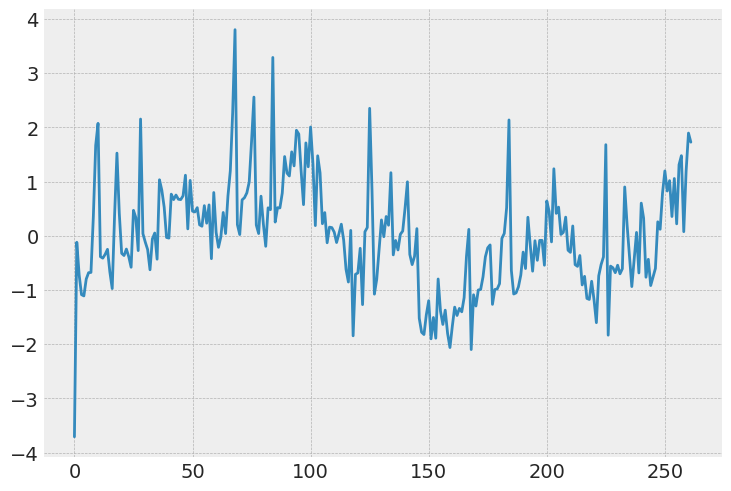

In [35]:
plt.plot(g['train']['data'].T[0]);

In [36]:
g['train']['data'] = g['train']['data'].T

In [37]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [38]:
changepoints = 4
changepoints_t = np.linspace(0, groups['train']['n'], changepoints + 2)[1:-1]
changepoints_t

array([ 52.4, 104.8, 157.2, 209.6])

In [39]:
class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*X+ (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise

In [40]:
n_samples = 200
n = groups['predict']['n']
s = groups['predict']['s']

In [ ]:
p_s_fit = []
p_s_predict = []

σ_list = [0.001, 0.01]

for i in range(groups['train']['s']):
        
        for sig in σ_list:
            try:
                with pm.Model() as model:
                    period = pm.Gamma('period', 40, 10)

                    l_t = pm.InverseGamma('l_t', 4, 40)
                    l_p = pm.HalfNormal('l_p', 0.5)
                    η_trend = pm.HalfNormal('η_trend',1)
                    η_per = pm.HalfNormal('η_per',1.5)
                    print(sig)
                    σ  = pm.HalfNormal("σ",  sigma=sig)

                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP 
                    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                            + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                            + pm.gp.cov.WhiteNoise(σ))

                    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                    f = gp.prior('f', X=X, reparameterize=True)

                    k = pm.Normal("k", mu=0, sigma=0.01)
                    m = pm.Normal("m", mu=0, sigma=0.01)
                    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(len(changepoints_t),1))

                    piece = OutPiecewiseLinearChangepoints(k = k,
                                                          m = m,
                                                          b = delta,
                                                          changepoints = changepoints_t,
                                                          groups = g).build(X)
                    piece = piece.reshape((-1,))

                    y_pred = pm.Normal('y_pred', mu=f + piece, observed=g['train']['data'][i])
                    mp = pm.find_MAP(maxeval=10000, progressbar = False)
                break

            except:
                print(f'Error on fitting series {i}')
        
        try:
            with model:
                pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred], 
                                              samples=n_samples,
                                              progressbar=False)

                f_n = gp.conditional('f_n', Xnew=X_new)

                piece = OutPiecewiseLinearChangepoints(k = k,
                                                      m = m,
                                                      b = delta,
                                                      changepoints = changepoints_t,
                                                      groups = g).build(X_new)

                piece = piece.reshape((-1,))

                y_pred_new = pm.Normal("y_pred_new", 
                                        mu=f_n + piece, 
                                        shape=X_new.shape[0])

                pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                          vars=[y_pred_new], 
                                                          samples=n_samples,
                                                          progressbar = False)

            print('Predicted ' + str(i)+'/'+str(groups['train']['s']-1))
            p_s_fit.append(pred_samples_fit['y_pred'])
            p_s_predict.append(pred_samples_predict['y_pred_new'])
            
        except:
            print(f'Error on predicting series {i}')

In [ ]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 2, 0)
p_s_predict = p_s_predict.transpose(1, 2, 0)

In [ ]:
g['train']['data'] = g['train']['data'].T

In [ ]:
# Back transform the data and the predictions

p_s_fit_inv = dt.inv_transf_train_general(p_s_fit)
p_s_predict_inv = dt.inv_transf_predict_general(p_s_predict)
g = dt.inv_transf_train()

In [ ]:
visualize_fit(g, p_s_fit_inv, 8)

In [ ]:
visualize_predict(g, p_s_predict_inv, g['h'])

In [ ]:
results = calculate_metrics(p_s_predict_inv, groups)
metrics_to_table( results)

# One Series

In [64]:
p_s_fit = []
p_s_predict = []

with pm.Model() as model:
    period = pm.Gamma('period', 40, 10)

    l_t = pm.InverseGamma('l_t', 4, 40)
    l_p = pm.HalfNormal('l_p', 0.5)
    η_trend = pm.HalfNormal('η_trend',1)
    η_per = pm.HalfNormal('η_per',1.5)
    σ  = pm.HalfNormal("σ",  sigma=0.01)

    mu_func = pm.gp.mean.Zero()

    # cov function for the GP 
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
            + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    k = pm.Normal("k", mu=0, sigma=0.01)
    m = pm.Normal("m", mu=0, sigma=0.01)
    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(len(changepoints_t),1))

    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = changepoints_t,
                                          groups = g).build(X)
    piece = piece.reshape((-1,))

    y_pred = pm.Normal('y_pred', mu=f + piece, observed=g['train']['data'][1])
    mp = pm.find_MAP(maxeval=10000, progressbar = True)
        
with model:
    pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                  vars=[y_pred], 
                                  samples=n_samples,
                                  progressbar=True)

    f_n = gp.conditional('f_n', Xnew=X_new)

    piece = OutPiecewiseLinearChangepoints(k = k,
                                          m = m,
                                          b = delta,
                                          changepoints = changepoints_t,
                                          groups = g).build(X_new)

    piece = piece.reshape((-1,))

    y_pred_new = pm.Normal("y_pred_new", 
                            mu=f_n + piece, 
                            shape=X_new.shape[0])

    pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new], 
                                              samples=n_samples,
                                              progressbar = True)


INFO (theano.gof.compilelock): Refreshing lock /home/mach1ne/.theano/compiledir_Linux-5.4--generic-x86_64-with-debian-bullseye-sid-x86_64-3.7.9-64/lock_dir/lock


In [133]:
# Back transform the data and the predictions
pred = ((pred_samples_predict['y_pred_new'])*dt.std_data[1] + dt.mu_data[1])

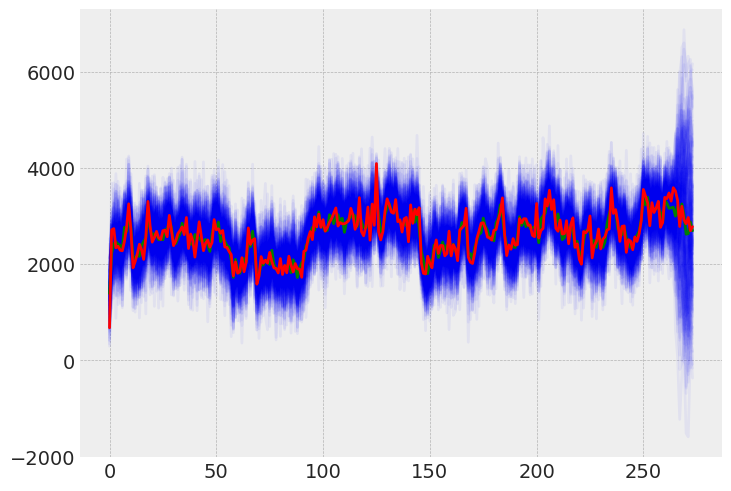

In [135]:
plt.plot(pred.T,alpha = 0.05, color='b')
plt.plot(np.mean(pred.T, axis=1), color='green')
plt.plot(g['predict']['data'].reshape(70, 274)[1], color='r');